# Chapter 4: Bayesian Statistics (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [2]:
geo_data = gp.read_pickle('../input_data/sandstone.pickle')

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_data_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"], verbose=1)

,EarlyGranite_Series,BIF_Series,SimpleMafic_Series
0,EarlyGranite,SimpleMafic2,SimpleMafic1
1,EarlyGranite,SimpleBIF,SimpleMafic1


In [4]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 100

geo_data.foliations['X_std'] = None
geo_data.foliations['Y_std'] = 0
geo_data.foliations['Z_std'] = 0

In [5]:
geo_data.foliations['dip_std'] = 10
geo_data.foliations['azimuth_std'] = 10
geo_data.foliations.head()

,X,Y,Z,azimuth,dip,polarity,formation,series,order_series,G_x,G_y,G_z,X_std,Y_std,Z_std,dip_std,azimuth_std
0,735082.0630,6879102.25,480.551436,276.153239,80.0,1,EarlyGranite,EarlyGranite_Series,1,-0.979134,0.105560,0.173648,None,0,0,10,10
1,715991.2815,6882773.25,505.165864,152.654159,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.452382,-0.874755,0.173648,None,0,0,10,10
2,728767.4065,6878759.25,470.031623,165.980598,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.238570,-0.955474,0.173648,None,0,0,10,10
3,730627.5315,6880472.50,477.402658,120.986348,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.844266,-0.507012,0.173648,None,0,0,10,10
4,732683.4690,6882332.75,481.711952,161.600709,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.310842,-0.934464,0.173648,None,0,0,10,10


In [6]:
interp_data = gp.InterpolatorInput(geo_data, compile_theano=False, u_grade=[3,3])

I am in the setting
float32
I am here
[2, 2]


In [7]:
interp_data.data.interfaces.head()

,X,Y,Z,formation,series,order_series,X_std,Y_std,Z_std,formation number
0,0.251624,0.2501,0.545482,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.00103,1
1,0.627614,0.30554,0.545444,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.00103,1
2,0.630638,0.389207,0.545792,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.00103,1
3,0.645758,0.375096,0.545853,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.00103,1
4,0.640718,0.328727,0.545622,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.00103,1


In [8]:
import pymc3 as pm

In [9]:
# with pm.Model():
#     Z = pm.Normal('Z_unc', interp_data.data.interfaces['Z'].as_matrix().astype('float'),
#                   interp_data.data.interfaces['Z_std'].as_matrix().astype('float'))

In [10]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph( interp_data.interpolator.tg.input_parameters_list(),
                              [interp_data.interpolator.tg.whole_block_model(0)], on_unused_input='ignore',
                            )

In [11]:
input_data_P = interp_data.get_input_data()

[3, 3]


In [12]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # Stochastic value
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype='float32', shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data.interpolator.ref_layer_points[:, 2].astype('float32'),
              interp_data.interpolator.ref_layer_points[:, 2].astype('float32'),
              dtype='float32', shape = (66))

    # We convert a python variable to theano.shared
    input_sh = []
    for i in input_data_P:
        input_sh.append(theano.shared(i))
        # We add the stochastic value to the correspondant array
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)

    geo_model = pm.Deterministic('GeMpy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/function_module.py:177: UserWarning: You are creating a TensorVaria

In [13]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, tune=10, init=None, step=step, )

  0%|          | 0/40 [00:00<?, ?it/s]/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.2776672870559196e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
100%|██████████| 40/40 [00:25<00:00,  2.03it/s]/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 30 samples.
  % (self._chain_id, n))
/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [15]:
input_data_T = interp_data.interpolator.tg.input_parameters_list()






select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [16]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(input_data_T, [interp_data.interpolator.tg.whole_block_model(0)], on_unused_input='ignore')

ValueError: Cannot compute test value: input 0 (Position of the dips) of Op Subtensor{int64:int64:, ::}(Position of the dips, ScalarFromTensor.0, ScalarFromTensor.0) missing default value.  
Backtrace when that variable is created:

  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5483455a72af>", line 1, in <module>
    interp_data = gp.InterpolatorInput(geo_data, compile_theano=False, u_grade=[3,3])
  File "../gempy/DataManagement.py", line 941, in __init__
    self.interpolator = self.set_interpolator(**kwargs)
  File "../gempy/DataManagement.py", line 1094, in set_interpolator
    interpolator = self.InterpolatorClass(geo_data_in, geo_data_in.grid, *args, **kwargs)
  File "../gempy/DataManagement.py", line 1185, in __init__
    self.tg = theanograf.TheanoGraph_pro(dtype=dtype, verbose=verbose,)
  File "../gempy/theanograf.py", line 94, in __init__
    self.dips_position_all = T.matrix("Position of the dips")


Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [ ]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
model = pm.Model()
with model:
    # Stochastic value
    reservoir = pm.Normal('reservoir', np.array([0], dtype='float64')
                          , sd=np.array([0.09], dtype='float64'), dtype='float64', shape=(1))
    
    # We convert a python variable to theano.shared
    ref = theano.shared(input_data_P[4])
    rest = theano.shared(input_data_P[5])
    
    # We add the stochastic value to the correspondant array
    ref = pm.Deterministic('reference', T.set_subtensor(
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))
    rest = pm.Deterministic('rest', T.set_subtensor(
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))#
  
    geo_model = pm.Deterministic('GeMpy', geomodel(theano.shared(input_data_P[0]),
                                                  theano.shared(input_data_P[1]),
                                                  theano.shared(input_data_P[2]),
                                                  theano.shared(input_data_P[3]),
                                                  ref, rest))

In [ ]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, init=None, step=step, )

In [ ]:
gp.trace.get_values('GeMpy')[0][-1,0,:])

In [ ]:
gp.plot_section(geo_data, trace.get_values('GeMpy')[0][-1, 0, :], 13,
                       direction='y', plot_data=False)

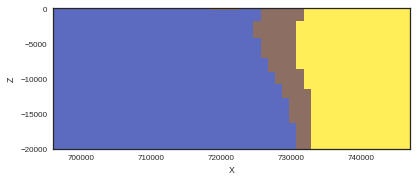

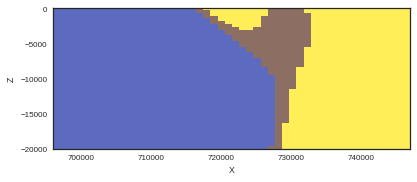

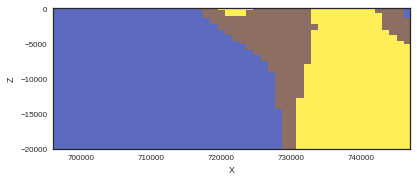

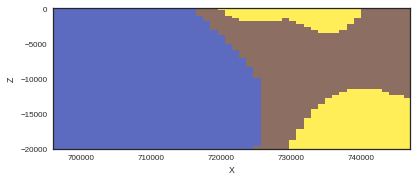

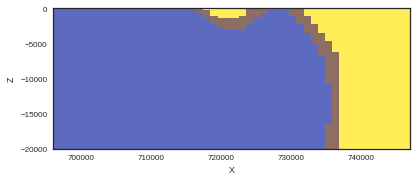

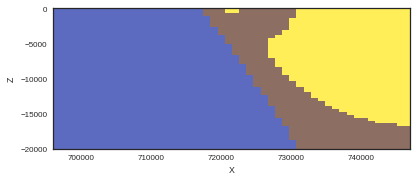

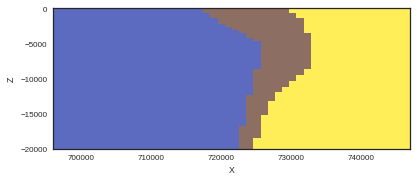

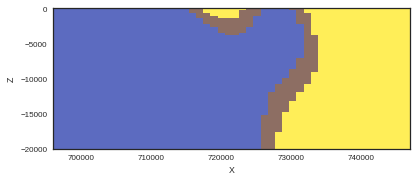

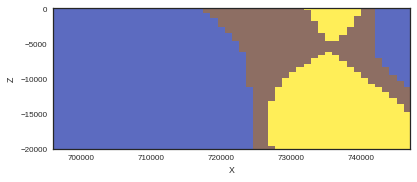

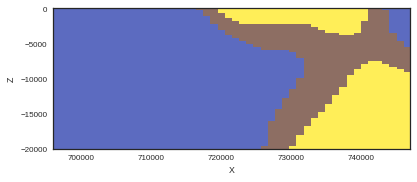

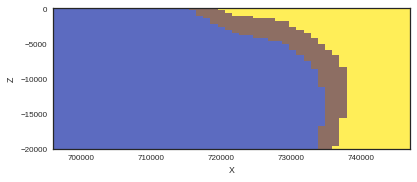

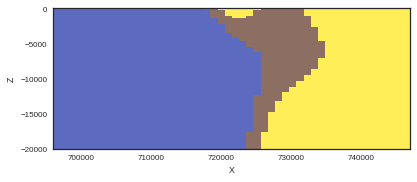

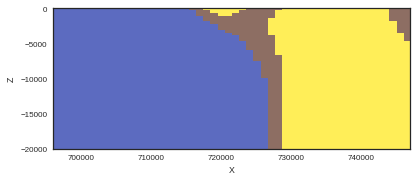

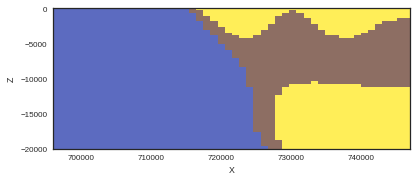

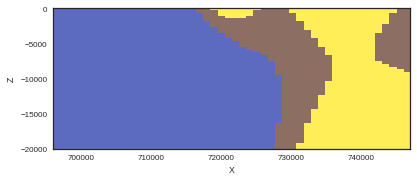

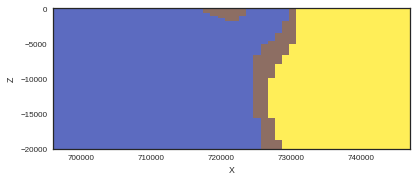

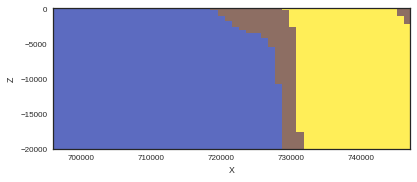

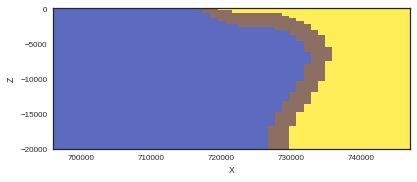

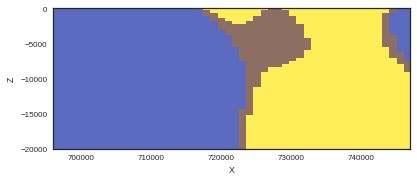

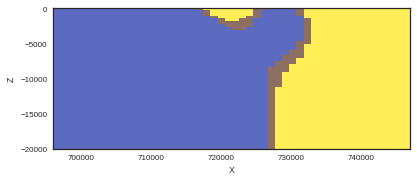

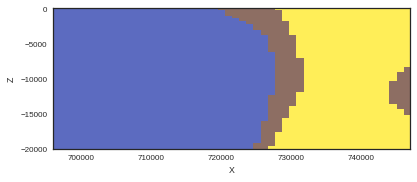

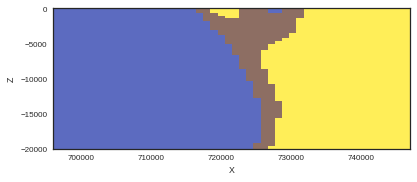

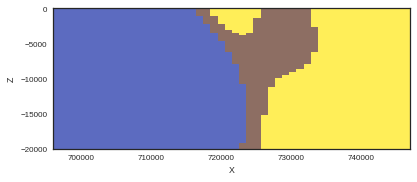

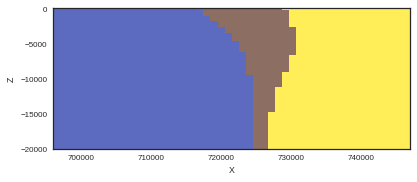

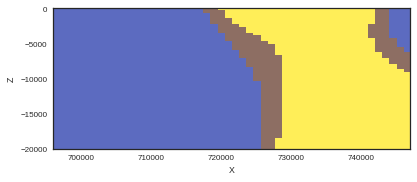

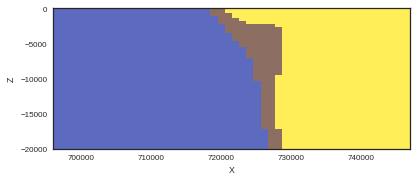

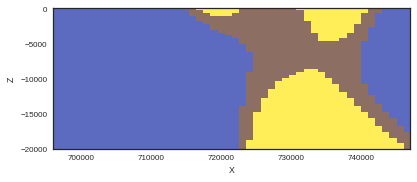

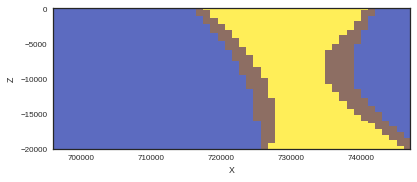

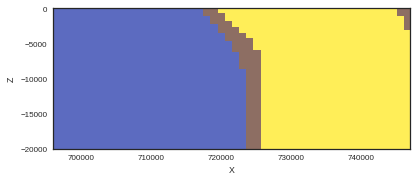

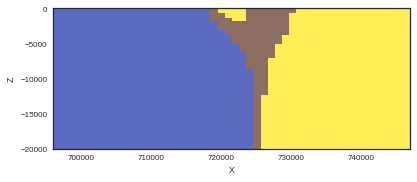

IndexError: index 30 is out of bounds for axis 0 with size 30

In [17]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GeMpy')[i][-1, 0, :], 13,
                       direction='y', plot_data=False)
    plt.show()

In [18]:
interp_data.interpolator.tg.u_grade_T.get_value()

array([3, 3])